In [1]:
import numpy as np
from numba import jit

def lloss(w1,w2,a,b,mu,var):
    loss = (1-a)*(1-b)*(w1+w2-1)**2 + a*b*(w1+w2+1)**2 + (1-a)*b*(w1-w2-1)**2 + a*(1-b)*(w1-w2+1)**2 + (w1+w2)**2 * (mu**2+var)
    return 0.5 * loss

@jit(nopython=True)
def irmv1_loss(w1,w2,a,b,lam,mu,var):
    loss = (1-a)*(1-b)*(w1+w2-1)**2 + a*b*(w1+w2+1)**2 + (1-a)*b*(w1-w2-1)**2 + a*(1-b)*(w1-w2+1)**2 + (w1+w2)**2 * (mu**2+var)
    re = (1-a)*(1-b)*(w1+w2-1)*(w1+w2) + a*b*(w1+w2+1)*(w1+w2) + (1-a)*b*(w1-w2-1)*(w1-w2) + a*(1-b)*(w1-w2+1)*(w1-w2) + (w1+w2)**2 * (mu**2+var)
    return 0.5 * loss + lam*(re**2)

@jit(nopython=True)
def rex_loss(w1,w2,a,b1,b2,i,mu1,var1,mu2,var2):
    a = 1-2*a
    b1 = 1-2*b1
    b2 = 1-2*b2
    
    loss1 = (w1**2+w2**2)*(1+mu1**2+var1) + 1 + 2*w1*w2*(a*b1+mu1**2+var1) - 2*w1*a - 2*w2*b1
    loss2 = (w1**2+w2**2)*(1+mu2**2+var2) + 1 + 2*w1*w2*(a*b2+mu2**2+var2) - 2*w1*a - 2*w2*b2
    
    if i==-1:
        lam = 0
        lamx = 1
    elif i<61:
        lam = 2**i
        lamx = 1
    elif i<121:
        lam = 2**60
        lamx = 2**(i-60)
    else:
        return lam*(loss1-loss2)**2
    return 0.5 * (loss1+loss2)/lamx + lam*(loss1-loss2)**2

@jit(nopython=True)
def icorr_loss(w1,w2,a,b1,b2,lam,mu1,var1,mu2,var2):
    loss1 = (1-a)*(1-b1)*(w1+w2-1)**2 + a*b1*(w1+w2+1)**2 + (1-a)*b1*(w1-w2-1)**2 + a*(1-b1)*(w1-w2+1)**2 + (w1+w2)**2 * (mu1**2+var1)
    re1 = (1-a)*(1-b1)*(w1+w2) - a*b1*(w1+w2) + (1-a)*b1*(w1-w2) - a*(1-b1)*(w1-w2)
    
    loss2 = (1-a)*(1-b2)*(w1+w2-1)**2 + a*b2*(w1+w2+1)**2 + (1-a)*b2*(w1-w2-1)**2 + a*(1-b2)*(w1-w2+1)**2 + (w1+w2)**2 * (mu2**2+var2)
    re2 = (1-a)*(1-b2)*(w1+w2) - a*b2*(w1+w2) + (1-a)*b2*(w1-w2) - a*(1-b2)*(w1-w2)
    return 0.5 * (loss1+loss2) + lam*(re1-re2)**2

In [2]:
#IRMv1
phi1 = []
phi2 = []

for i in range(-1,26):
    if i==-1:
        lam = 0
    else:
        lam = 2**i
    LL = 100
    ww1 = 0
    ww2 = 0
    for ii in range(1000):
        for jj in range(1000):
            w1 = ii/1000
            w2 = jj/1000
            ll = irmv1_loss(w1,w2,0.1,0.2,lam,0.2,0.01) + irmv1_loss(w1,w2,0.1,0.25,lam,0.1,0.02)
            if ll<LL:
                LL = ll
                ww1 = w1
                ww2 = w2
    #print(i)
    phi1.append(ww1+ww2)
    phi2.append(ww1-ww2)

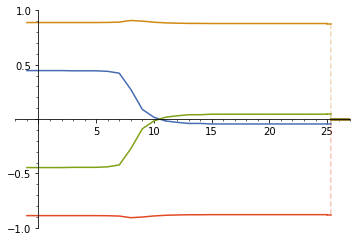

In [3]:
#IRMv1_output
x = []
for i in range(-1,26):
    x.append(i)
    
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data', 0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))


x_major_locator=MultipleLocator(5)
y_major_locator=MultipleLocator(0.5)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
yticks = ax.yaxis.get_major_ticks() 
yticks[3].label1.set_visible(False)
xticks = ax.xaxis.get_major_ticks() 
xticks[1].label1.set_visible(False)

xminorLocator = MultipleLocator(1) 
ax.xaxis.set_minor_locator(xminorLocator)
yminorLocator = MultipleLocator(0.1) 
ax.yaxis.set_minor_locator(yminorLocator)

plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

plt.plot(x,phi1,color=(208/255, 138/255, 17/255))
plt.plot(x,phi2,color=(71/255, 108/255, 179/255))

plt.plot(x,-np.array(phi1),color=(227/255, 73/255, 37/255))
plt.plot(x,-np.array(phi2),color=(128/255, 161/255, 22/255))


plt.plot([x[-1],25.32],[phi1[-1],phi1[-1]],color=(208/255, 138/255, 17/255))
plt.plot([x[-1],25.32],[phi2[-1],phi2[-1]],color=(71/255, 108/255, 179/255))

plt.plot([x[-1],25.32],-np.array([phi1[-1],phi1[-1]]),color=(227/255, 73/255, 37/255))
plt.plot([x[-1],25.32],-np.array([phi2[-1],phi2[-1]]),color=(128/255, 161/255, 22/255))


plt.plot([25.32,25.33],[phi1[-1],0],color=(208/255, 138/255, 17/255),linestyle='--',alpha=0.3)
plt.plot([25.32,25.33],[phi2[-1],0],color=(71/255, 108/255, 179/255),linestyle='--',alpha=0.3)

plt.plot([25.32,25.33],-np.array([phi1[-1],0]),color=(227/255, 73/255, 37/255),linestyle='--',alpha=0.3)
plt.plot([25.32,25.33],-np.array([phi2[-1],0]),color=(128/255, 161/255, 22/255),linestyle='--',alpha=0.3)


plt.plot([25.34,27],[0,0],color=(208/255, 138/255, 17/255),linewidth=3,alpha=0.5)
plt.plot([25.34,27],[0,0],color=(71/255, 108/255, 179/255),linewidth=3,alpha=0.5)

plt.plot([25.34,27],-np.array([0,0]),color=(227/255, 73/255, 37/255),linewidth=3,alpha=0.5)
plt.plot([25.34,27],-np.array([0,0]),color=(128/255, 161/255, 22/255),linewidth=3,alpha=0.5)

plt.ylim((-1, 1))
plt.xlim((-2, 27))
plt.show()

In [4]:
#ICorr
phi1 = []
phi2 = []
for i in range(-1,28):
    if i==-1:
        lam = 0
    else:
        lam = 2**i
        
    LL = 100
    ww1 = 0
    ww2 = 0
    for ii in range(1000):
        for jj in range(1000):
            w1 = ii/1000
            w2 = jj/1000
            ll = icorr_loss(w1,w2,0.1,0.2,0.25,lam,0.2,0.01,0.1,0.02)
            if ll<LL:
                LL = ll
                ww1 = w1
                ww2 = w2
    #print(i)
    phi1.append(ww1+ww2)
    phi2.append(ww1-ww2)

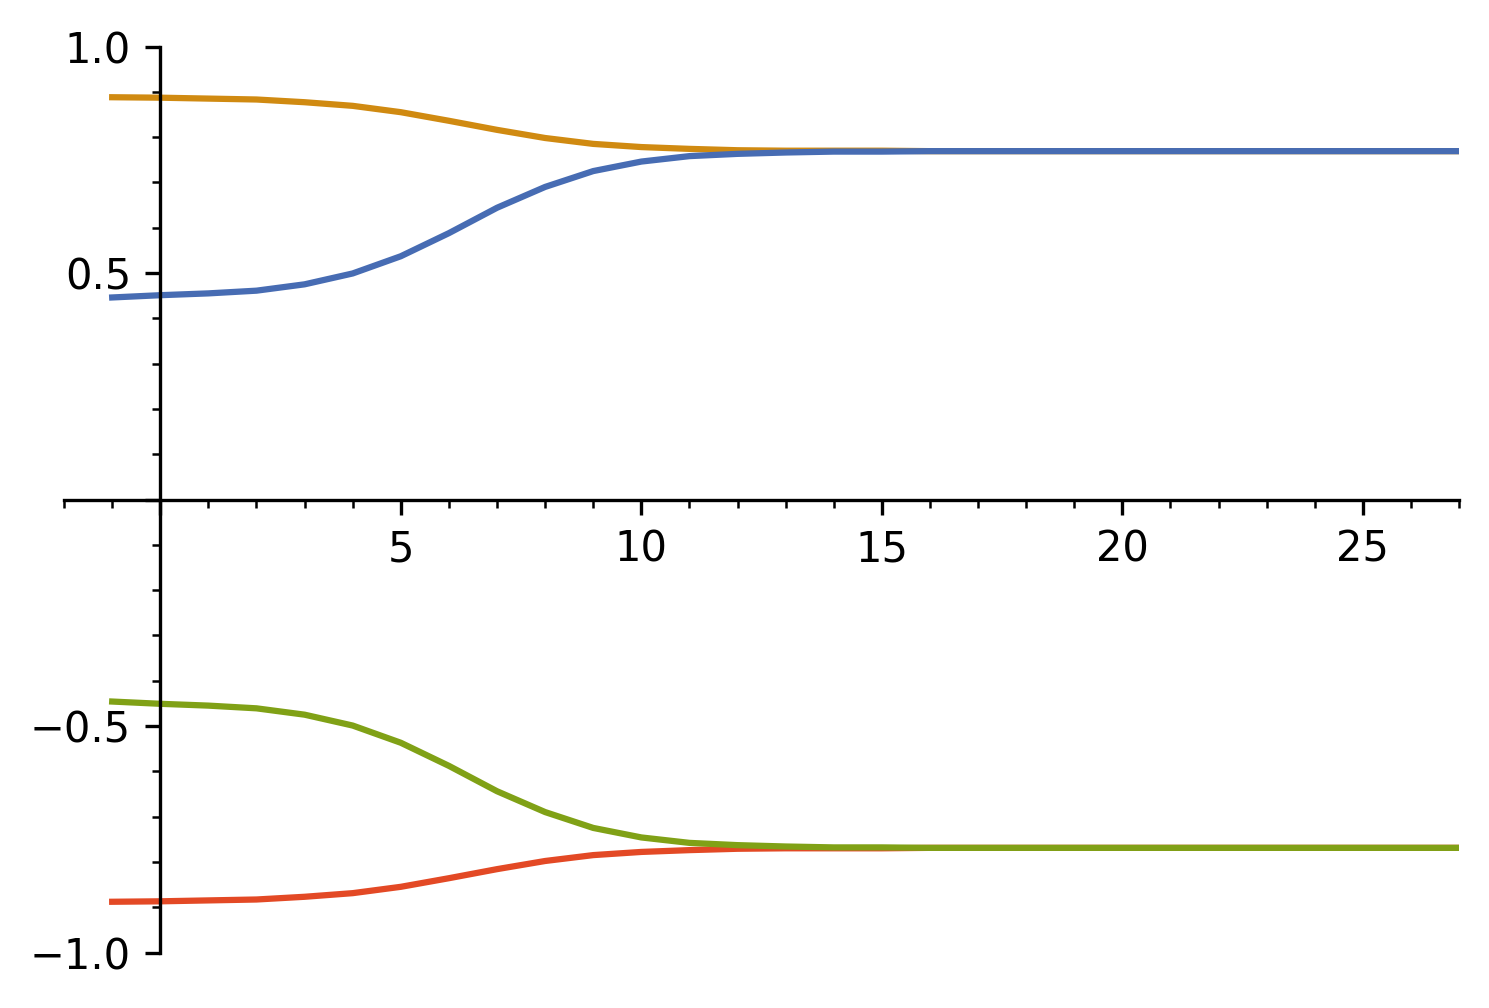

In [5]:
#ICorr_output
x = []
for i in range(-1,28):
    x.append(i)
    
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data', 0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))

x_major_locator=MultipleLocator(5)
y_major_locator=MultipleLocator(0.5)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
yticks = ax.yaxis.get_major_ticks() 
yticks[3].label1.set_visible(False)
xticks = ax.xaxis.get_major_ticks() 
xticks[1].label1.set_visible(False)

xminorLocator = MultipleLocator(1) 
ax.xaxis.set_minor_locator(xminorLocator)
yminorLocator = MultipleLocator(0.1) 
ax.yaxis.set_minor_locator(yminorLocator)

plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

plt.plot(x,phi1,color=(208/255, 138/255, 17/255))
plt.plot(x,phi2,color=(71/255, 108/255, 179/255))

plt.plot(x,-np.array(phi1),color=(227/255, 73/255, 37/255))
plt.plot(x,-np.array(phi2),color=(128/255, 161/255, 22/255))

plt.ylim((-1, 1))
plt.xlim((-2, 27))
plt.show()

In [6]:
#rex
phi1 = []
phi2 = []
for i in range(-1,131):       
    LL = 100
    ww1 = 0
    ww2 = 0
    for ii in range(1000):
        for jj in range(1000):
            w1 = ii/1000
            w2 = jj/1000
            ll = rex_loss(w1,w2,0.1,0.2,0.25,i,0.2,0.01,0.1,0.02)
            if ll<LL:
                LL = ll
                ww1 = w1
                ww2 = w2
    #print(i, end=', ')
    phi1.append(ww1+ww2)
    phi2.append(ww1-ww2)

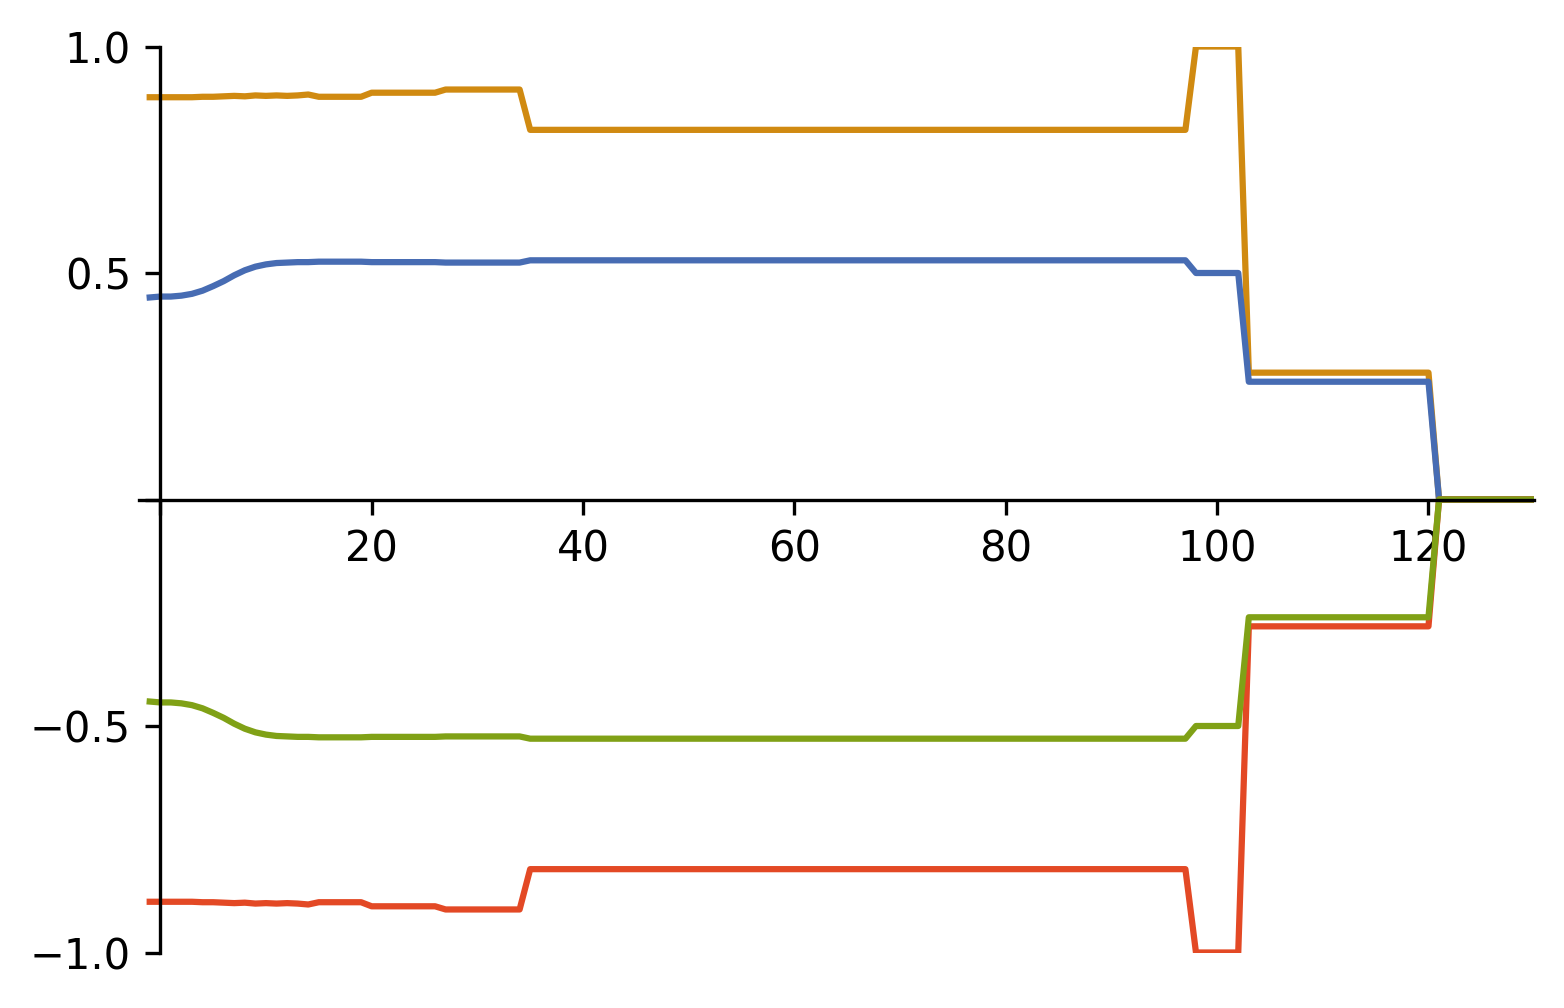

In [7]:
#rex_output
x = []
for i in range(-1,131):
    x.append(i)
    
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator

fig, ax = plt.subplots()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.xaxis.set_ticks_position('bottom')
ax.spines['bottom'].set_position(('data', 0))
ax.yaxis.set_ticks_position('left')
ax.spines['left'].set_position(('data', 0))


x_major_locator=MultipleLocator(20)
y_major_locator=MultipleLocator(0.5)
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
yticks = ax.yaxis.get_major_ticks() 
yticks[3].label1.set_visible(False)
xticks = ax.xaxis.get_major_ticks() 
xticks[1].label1.set_visible(False)

plt.rcParams['figure.figsize'] = (6.0, 4.0)
plt.rcParams['savefig.dpi'] = 300 
plt.rcParams['figure.dpi'] = 300

plt.plot(x,phi1,color=(208/255, 138/255, 17/255))
plt.plot(x,phi2,color=(71/255, 108/255, 179/255))

plt.plot(x,-np.array(phi1),color=(227/255, 73/255, 37/255))
plt.plot(x,-np.array(phi2),color=(128/255, 161/255, 22/255))

plt.ylim((-1, 1))
plt.xlim((-2, 130))
plt.show()